# Imports

In [1]:
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

In [2]:
import imageio
from pathlib import Path
from matplotlib.pyplot import show
from argparse import ArgumentParser

from pyoptflow.plots import compareGraphs

In [28]:
from PIL import Image
import os
from scipy.signal import argrelextrema
from skimage import exposure
import string

In [4]:
import matplotlib
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [5]:
epsilon = 1/1000

### Import our custom utility methods

In [6]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse

The following modules are available

In [7]:
print_module_methods(utils.diverse)

NestedDict()

print_module_methods(module)

set_random_state(seed_value=42)

slow_wave_features(dataset, features, where=None)



In [8]:
print_module_methods(utils.visualization_tools)

HTML(data=None, url=None, filename=None, metadata=None)

display_combined(u, v, Inew, scale=100, quivstep=3, fig=None, ax=None, figsize=(10, 10), vmin=0, vmax=1, head_width=1, mode='minimal')

fig2rgb_array(fig)

manifold(decoder, x_range=[-2, 2], y_range=[-0.5, -2.5], n=10, figsize=(8, 8), dpi=100, n_interp=100, scale='sqrt')

plot_animation(vectors, i_min=0, n_frames=10, norm=True)

plot_vector_as_field(y, x, scale=1)

print_points_and_background(img, x, y, point_size=10, marker='.')

render_arrow_components(up=1, down=1, left=1, right=1, cmap='Blues')

show_video(frames, frames1=None, n_frames=20, startframe=0, orient='horizontal', figsize=(10, 10), vmin=0, vmax=1, cmap='viridis', show_framenumber=True, jshtml=True)

stretch(vector, n_interp, norm=True)

superimpose(img, background, cm_background=<matplotlib.colors.LinearSegmentedColormap object at 0x7f074b4c3110>, cm_foreground=<matplotlib.colors.ListedColormap object at 0x7f074b4da390>)

vector_field_animation(y_comp, x_comp, tens

In [9]:
print_module_methods(utils.data_transformations)

HornSchunck(im1: numpy.ndarray, im2: numpy.ndarray, alpha: float = 0.001, Niter: int = 8, verbose: bool = False) -> Tuple[numpy.ndarray, numpy.ndarray]

PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

apply_mask(frames, mask, nan=False)

argrelextrema(data, comparator, axis=0, order=1, mode='clip')

binary_dilation(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)

binary_erosion(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)

butter_bandstop_filter(data, lowcut, highcut, fs, order)

center_of_mass(a)

clipped_adaptive(tensor, clipping=0.8)

dilate_median(tensor, mask, iterations=10)

discard_minor_components(tensor, keep_components=3, n_components=None, pca=None, fit_only=False)

equalize_adapthist(image, kernel_size=None, clip_limit=0.

# Example field with source sink and curl

In [10]:
from pynhhd import nHHD

def natural_helmholtz_decompositon(vfield):
    """ Computes the natural Helmholtz decomposition for a single 2D vector field
    Args:
        vfield: A vector field of shape [2, width, height] where the y component comes first. 
        This could either be a numpy array or a list [y_component, x_component] where both y_component and x_component refer to 2d numpy arrays.
    Returns:
        solenoidal: Solenoidal vector field (divergence free)
        curl_free: Curl free vector field (divergent field)
        harmonic: Harmonic component vector field
        solenoidal_potential: 2d numpy array
        curl_free_potential: 2d numpy array
        divergence: Divergence of the original vector field. 2d numpy array.
    """
    vfield = [vfield[1], vfield[0]]
    vfield = np.einsum("ijk->kij", vfield)
    vfield = np.einsum("ijk->kij", vfield)
    
    dims = (vfield.shape[0],vfield.shape[1])
    nhhd = nHHD(grid=dims, spacings=(0.1,0.1))
    nhhd.decompose(vfield)
    
    solenoidal = np.array([nhhd.r[:,:,1], nhhd.r[:,:,0]])
    curl_free = np.array([nhhd.d[:,:,1], nhhd.d[:,:,0]])
    harmonic = np.array([nhhd.h[:,:,1], nhhd.h[:,:,0]])
    solenoidal_potential = nhhd.nRu
    curl_free_potential = nhhd.nD
    divergence = nhhd.div
    return solenoidal, curl_free, harmonic, solenoidal_potential, curl_free_potential, divergence

In [11]:
def source_sink_and_curl(sink=False, source=False, curl_left = False, curl_right = False):
    """ Returns a vector field that potentially contains a source a sink and two curls
    Args:
        sink: Specifies wheather a sink should be in the data
        source: Specifies wheather a source should be in the data
        curl_left: Specifies whether a curl with leftwards rotation shall be in the data
        curl_right: Specifies whether a curl with rightwards rotation shall be in the data
    Return:
        vfield: A list of 2d arrays for the y and x components of the vector
    """
    x_comps = []
    y_comps = []
    # 1. sink
    if sink:
        shape = (130, 130)
        arr = np.zeros(shape)#sink
        arr[35:45,35:45] = 1#top left
        arr = gaussian_filter(arr, 10)
        y_comp1, x_comp1 = np.array(np.gradient(arr))*100
        x_comps.append(x_comp1)
        y_comps.append(y_comp1)

    if source:
        # 2. source
        arr = np.zeros(shape)#source
        arr[35:45,-45:-35] = 1#top right
        arr = gaussian_filter(arr, 10)
        y_comp2, x_comp2 = np.array(np.gradient(arr))*100
        x_comp2 *= -1
        y_comp2 *= -1
        x_comps.append(x_comp2)
        y_comps.append(y_comp2)
        
    if curl_left:
        # 3. curl leftwards
        arr = np.zeros(shape)#curl leftwards
        arr[-45:-35,35:45] = 1#bottom left
        arr = gaussian_filter(arr, 10)
        x_comp3, y_comp3 = np.array(np.gradient(arr))*100#x and y flipped
        x_comp3 *= -1
        x_comps.append(x_comp3)
        y_comps.append(y_comp3)
    
    if curl_right:
        # 4. curl rightwards
        arr = np.zeros(shape)#curl rightwards
        arr[-45:-35,-45:-35] = 1#bottom right
        arr = gaussian_filter(arr, 10)
        x_comp4, y_comp4 = np.array(np.gradient(arr))*100
        y_comp4 *= -1
        x_comps.append(x_comp4)
        y_comps.append(y_comp4)
    
    #Combine vector fields
    x_comp = np.sum(np.array(x_comps), axis=(0))
    y_comp = np.sum(np.array(y_comps), axis=(0))
    return y_comp, x_comp

def divergence(f):
    """ Computes the divergence for each position of the provided vector field
    Args:
        f: Vector field in the form of a numpy array of shape [2, width, height]
    Returns:
        Divergence for each position in a numpy array of shape [width, height]    
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], axis=i) for i in range(num_dims)])

def vector_field(function, shape = 100, min = 0, max = 10):
    """ Creates a vector field from a 2d function.
    Args:
        function: A python callable (a lambda expression or a function)
        shape: Width/Height of the output vector field
        min: Minimal value for x and y
        max: Maximal value for x and y
    """
    width = max-min
    factor = width/shape
    arr = np.ndarray(shape=(shape,shape,2))
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            arr[y, x] = function(min+y*factor,min+x*factor)
    arr = np.einsum("ijk->kij", arr)
    return arr

def solenoidal_field(x, y):
    return y, -x

def mixed_field(x, y):
    return np.cos(x+2*y), np.sin(x-2*y)

In [37]:
import string
def plot_solenoidal_and_curl_free(vfield, scale= 2):
    fig = plt.figure(figsize=(15,10))
    ax = []
    gs = fig.add_gridspec(2, 3)
    ax.append(fig.add_subplot(gs[:, :2]))
    ax.append(fig.add_subplot(gs[0, 2:]))
    ax.append(fig.add_subplot(gs[1, 2:]))


    display_combined(vfield[0], vfield[1], np.sqrt(vfield[1]**2+vfield[0]**2), scale=scale, fig=fig, ax = ax[0])

    solenoidal, curl_free, harmonic, solenoidal_potential, curl_free_potential, div = natural_helmholtz_decompositon(vfield)
    
    display_combined(curl_free[0],curl_free[1], normalize(curl_free_potential), scale=scale, fig=fig, ax=ax[1])
    display_combined(solenoidal[0],solenoidal[1], normalize(solenoidal_potential), scale=scale, fig=fig, ax=ax[2])
    
    ax[0].set_title("Original vector field", fontsize=25)
    ax[1].set_title("Sources and sinks", fontsize=25)
    ax[2].set_title("Flow", fontsize=25)
    
    for i, a in enumerate(ax):
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.text(-0.03, 1.03, string.ascii_uppercase[i], transform = a.transAxes, size= 25, weight = "bold")


    plt.tight_layout()
    plt.show()

    epsilon = 0.0001
    assert np.sum(divergence([solenoidal[0], solenoidal[1]])) < epsilon
    print("The divergence of the solenoidal vector field is zero")
    return fig

In [43]:
vfield = source_sink_and_curl(True, True, True, True)
res = natural_helmholtz_decompositon(vfield)
solenoidal, curl_free, harmonic, solenoidal_potential, curl_free_potential, div = res

Text(0.5, 1.0, 'Divergence')

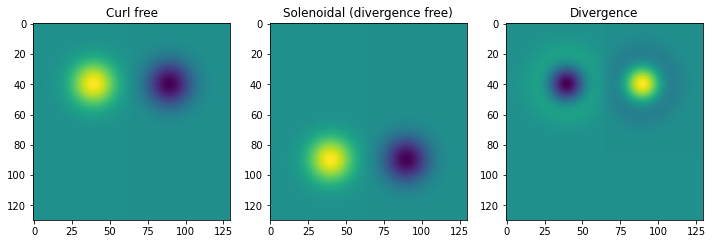

In [44]:
curl_free_potential, solenoidal_potential = normalize([curl_free_potential, solenoidal_potential])
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(curl_free_potential, vmin = 0, vmax=1)
ax[1].imshow(solenoidal_potential, vmin=0, vmax=1)
ax[2].imshow(div)
ax[0].set_title("Curl free")
ax[1].set_title("Solenoidal (divergence free)")
ax[2].set_title("Divergence")

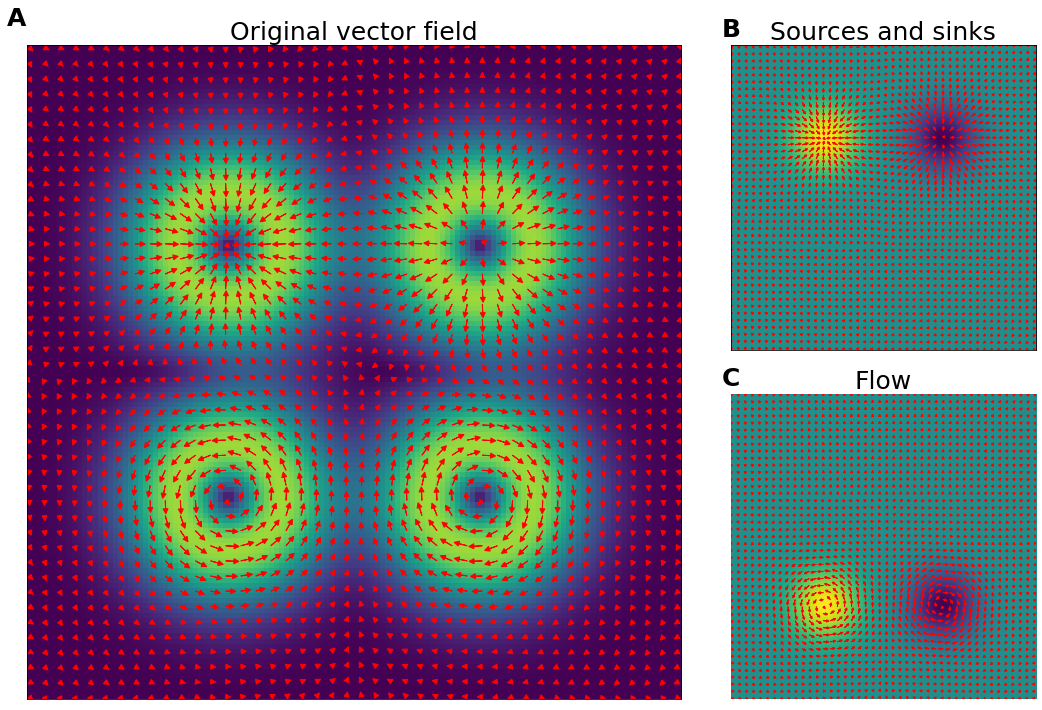

The divergence of the solenoidal vector field is zero


In [45]:
fig = plot_solenoidal_and_curl_free(vfield)
fig.savefig("helmholtz_decomposition.png")

In [40]:
#Crossvalidate divergence methods
#assert np.sum(div - divergence(vfield)) < epsilon

# Decomposition of a typical example

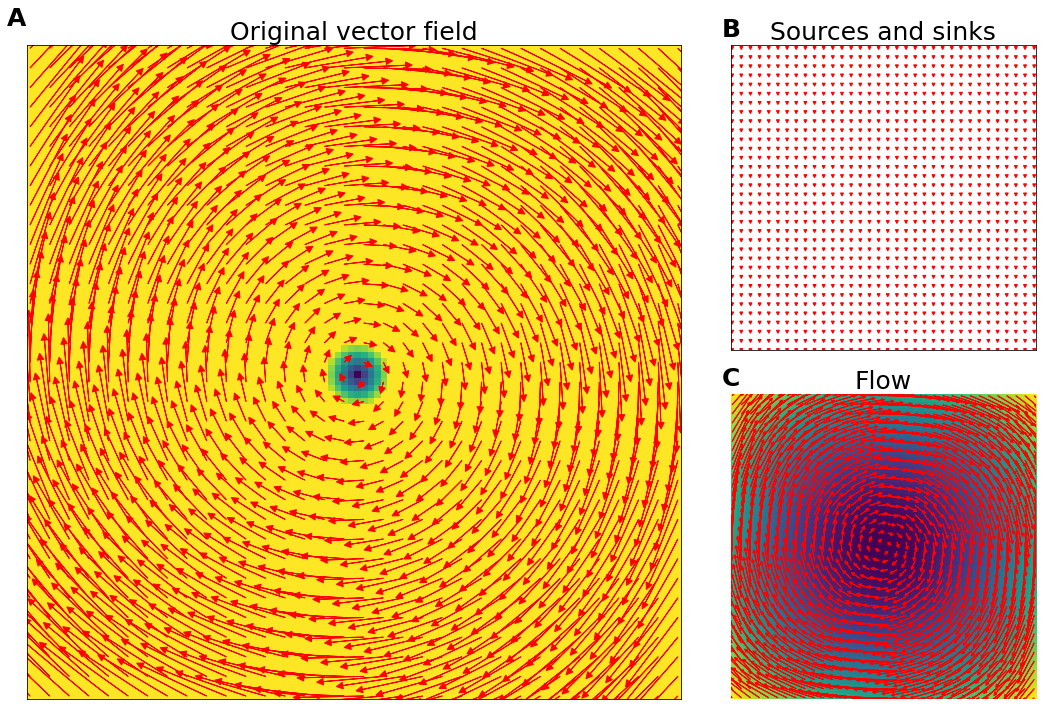

The divergence of the solenoidal vector field is zero


In [41]:
vfield = vector_field(solenoidal_field, min=-10)
fig = plot_solenoidal_and_curl_free(vfield, scale=1)
fig.savefig("helmholtz_decomposition_1.png")

==> No divergence as expected

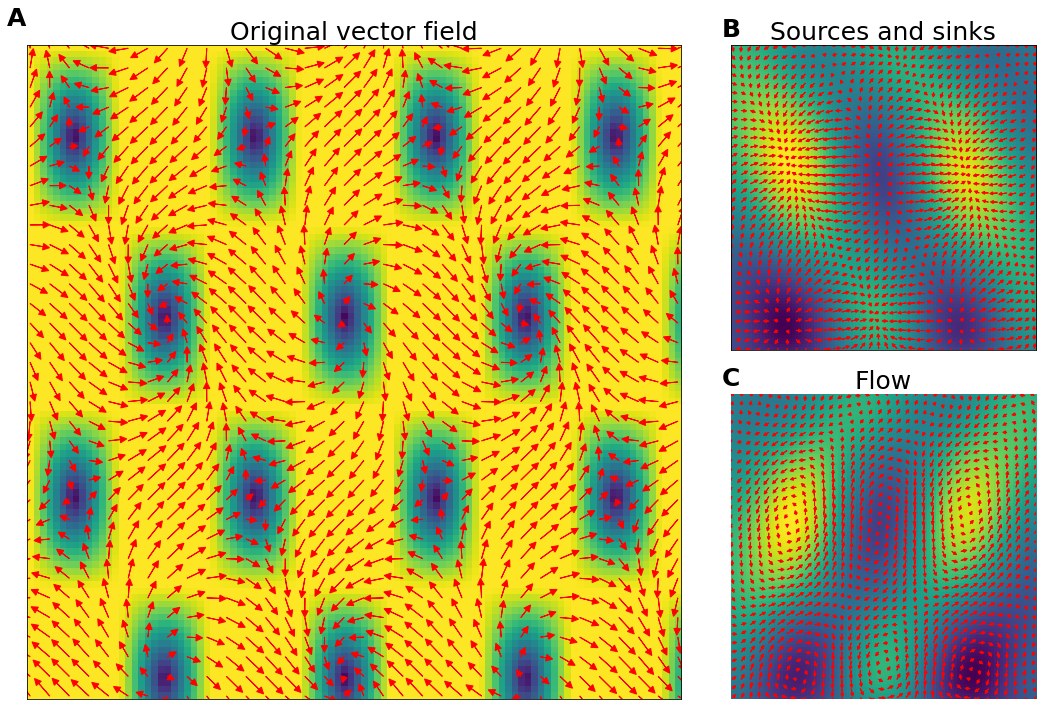

The divergence of the solenoidal vector field is zero


In [42]:
vfield = vector_field(mixed_field, 100, 3.14*5)
fig = plot_solenoidal_and_curl_free(vfield)
fig.savefig("helmholtz_decomposition_2.png")

# Conclusion

Works as expected. Good starting point.